In [1]:
import torch
import torch.nn as nn
import torchvision
import numpy as np
from torch.utils.data import Dataset, DataLoader
import glob
import torchvision.utils as vutils
from PIL import Image
import matplotlib.animation as animation
from IPython.display import HTML
import os

In [2]:
from torchvision import transforms
transform = transforms.Compose(
    [transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
    ])

In [3]:
transform_back = transforms.Compose(
    [transforms.Resize([32, 32])])

In [4]:
class MyDataset(Dataset):
    def __init__(self, data_path, transform = None):
        self.data_path = data_path
        self.transform = transform
        self.img_list = []
        self.label_list = []
        for file in glob.glob(self.data_path  + '/*.png'):
            cur_path = file.replace('\\','/')
            self.img_list.append(cur_path)
        lable = np.ones(len(self.img_list))
        self.label_list = lable.tolist()
    
    def __len__(self):
        return len(self.img_list)
    
    def __getitem__(self, idx):
        img = Image.open(self.img_list[idx]).convert('RGB')
        #img = img.resize((224,224)), Image.ANTIALIAS)
        if self.transform is not None:
            img = self.transform(img)
        label = self.label_list[idx]
        return img, label

cuda:0


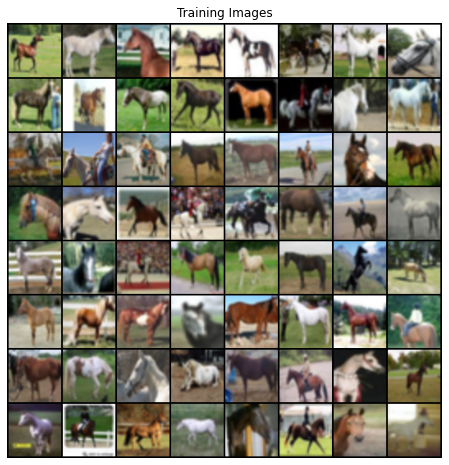

In [5]:
# load data from C:\Users\86180\Desktop\myDL\GAN\cifar10_horse\train
train_dataset = MyDataset(data_path='C:/Users/86180/Desktop/myDL/GAN/cifar10_horse/train', transform = transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# set the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# Plot some training images
import matplotlib.pyplot as plt
real_batch = next(iter(train_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [6]:
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [7]:
image_size = 64
nz = 100 # size of the latent z vector
ngf = 64 # size of feature maps in the generator
ndf = 64 # size of feature maps in the discriminator
nc = 3 # number of channels in the image
num_epochs = 200 # number of epochs to train for
lr = 0.0002 # learning rate for optimizers
beta1 = 0.5 # beta1 for Adam optimizers
ngpu = 1 # number of GPUs available. Use 0 for CPU mode
real_img_path = 'C:/Users/86180/Desktop/myDL/GAN/cifar10_horse_resize/train/'
fake_img_path = 'C:/Users/86180/Desktop/myDL/GAN/cifar10_horse_resize/' + 'output_ep' + str(num_epochs)
path = [real_img_path, fake_img_path]

In [8]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


In [9]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [10]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [11]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)


Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [12]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [13]:
import torch.optim as optim

#  Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(image_size, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))


In [14]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(train_loader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0) # batch size
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(train_loader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(train_loader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1
    # generate images per 10 epochs and save them
    if ((epoch + 1) % 10 == 0):
        path_save = './cifar10_horse_resize/possession/'
        if not os.path.exists(path_save):
            os.makedirs(path_save)
        with torch.no_grad():
            fake = netG(fixed_noise).detach().cpu()
        vutils.save_image(fake, path_save + 'fake_samples_epoch_%d.png' % (epoch + 1), normalize=True)

Starting Training Loop...
[0/1000][0/79]	Loss_D: 1.3572	Loss_G: 4.9655	D(x): 0.4890	D(G(z)): 0.3538 / 0.0083
[0/1000][50/79]	Loss_D: 0.5627	Loss_G: 26.0955	D(x): 0.6545	D(G(z)): 0.0000 / 0.0000
[1/1000][0/79]	Loss_D: 0.0034	Loss_G: 34.3747	D(x): 0.9966	D(G(z)): 0.0000 / 0.0000
[1/1000][50/79]	Loss_D: 0.3344	Loss_G: 18.9355	D(x): 0.8339	D(G(z)): 0.0000 / 0.0000
[2/1000][0/79]	Loss_D: 0.5805	Loss_G: 3.1343	D(x): 0.6971	D(G(z)): 0.0866 / 0.0609


KeyboardInterrupt: 

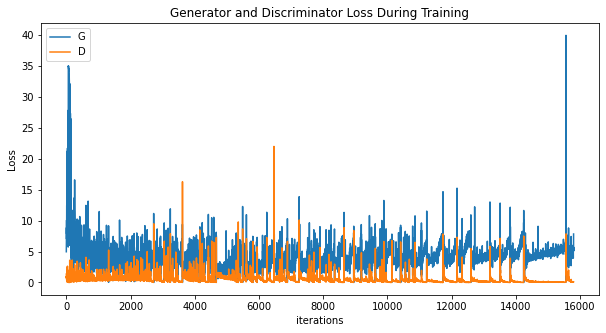

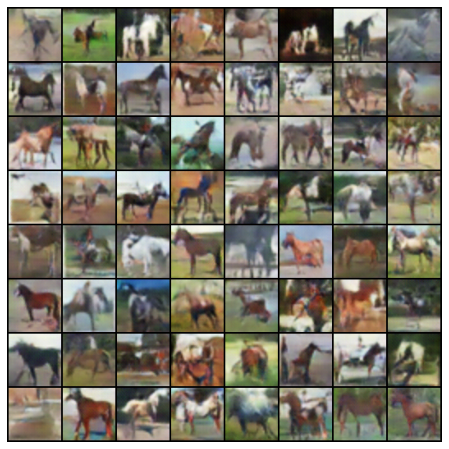

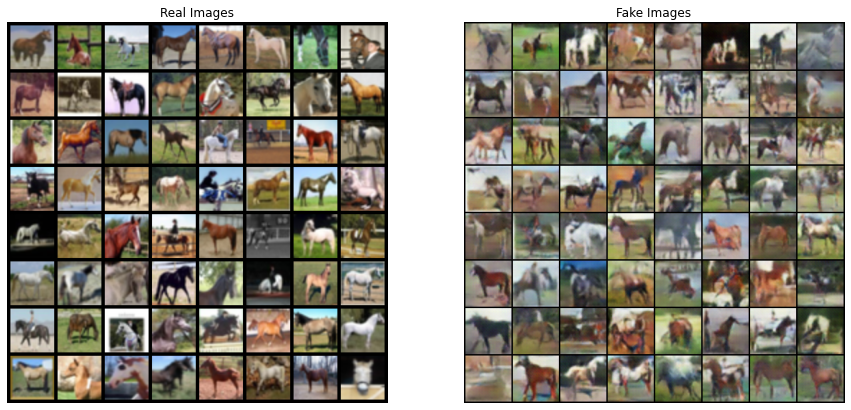

In [ ]:
plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses, label="G")
plt.plot(D_losses, label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

# Grab a batch of real images from the dataloader
real_batch = next(iter(train_loader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()


In [ ]:
netG.eval()
import os
path_to_save = fake_img_path +'/'
if not os.path.exists(path_to_save):
    os.makedirs(path_to_save)
for i in range(1000):
    z_sample = torch.randn(1, nz, 1, 1, device=device)
    fake = netG(z_sample)
    fake = transform_back(fake)
    file_name = path_to_save + str(i) + '.png'
    vutils.save_image(fake, file_name, normalize=True)



In [ ]:
from fid_score.fid_score import FidScore
batch_size = 64
fid = FidScore(path, device, batch_size)
score = fid.calculate_fid_score()
print("the score of this model is:", score)

  0%|          | 0/79 [00:00<?, ?it/s]

Present batch 1/64

  1%|▏         | 1/79 [00:00<00:51,  1.53it/s]

done
Present batch 65/64

  3%|▎         | 2/79 [00:01<00:36,  2.11it/s]

done
Present batch 129/64

  4%|▍         | 3/79 [00:01<00:30,  2.46it/s]

done
Present batch 193/64

  5%|▌         | 4/79 [00:01<00:27,  2.69it/s]

done
Present batch 257/64

  6%|▋         | 5/79 [00:01<00:25,  2.87it/s]

done
Present batch 321/64

  8%|▊         | 6/79 [00:02<00:24,  2.98it/s]

done
Present batch 385/64

  9%|▉         | 7/79 [00:02<00:23,  3.06it/s]

done
Present batch 449/64

 10%|█         | 8/79 [00:02<00:22,  3.11it/s]

done
Present batch 513/64

 11%|█▏        | 9/79 [00:03<00:22,  3.14it/s]

done
Present batch 577/64

 13%|█▎        | 10/79 [00:03<00:22,  3.13it/s]

done
Present batch 641/64

 14%|█▍        | 11/79 [00:03<00:21,  3.15it/s]

done
Present batch 705/64

 15%|█▌        | 12/79 [00:04<00:21,  3.18it/s]

done
Present batch 769/64

 16%|█▋        | 13/79 [00:04<00:20,  3.24it/s]

done
Present batch 833/64

 18%|█▊        | 14/79 [00:04<00:19,  3.28it/s]

done
Present batch 897/64

 19%|█▉        | 15/79 [00:05<00:19,  3.32it/s]

done
Present batch 961/64

 20%|██        | 16/79 [00:05<00:19,  3.31it/s]

done
Present batch 1025/64

 22%|██▏       | 17/79 [00:05<00:18,  3.31it/s]

done
Present batch 1089/64

 23%|██▎       | 18/79 [00:05<00:18,  3.27it/s]

done
Present batch 1153/64

 24%|██▍       | 19/79 [00:06<00:18,  3.22it/s]

done
Present batch 1217/64

 25%|██▌       | 20/79 [00:06<00:18,  3.22it/s]

done
Present batch 1281/64

 27%|██▋       | 21/79 [00:06<00:17,  3.26it/s]

done
Present batch 1345/64

 28%|██▊       | 22/79 [00:07<00:17,  3.26it/s]

done
Present batch 1409/64

 29%|██▉       | 23/79 [00:07<00:16,  3.31it/s]

done
Present batch 1473/64

 30%|███       | 24/79 [00:07<00:16,  3.34it/s]

done
Present batch 1537/64

 32%|███▏      | 25/79 [00:08<00:16,  3.35it/s]

done
Present batch 1601/64

 33%|███▎      | 26/79 [00:08<00:15,  3.35it/s]

done
Present batch 1665/64

 34%|███▍      | 27/79 [00:08<00:15,  3.33it/s]

done
Present batch 1729/64

 35%|███▌      | 28/79 [00:08<00:15,  3.26it/s]

done
Present batch 1793/64

 37%|███▋      | 29/79 [00:09<00:15,  3.22it/s]

done
Present batch 1857/64

 38%|███▊      | 30/79 [00:09<00:14,  3.27it/s]

done
Present batch 1921/64

 39%|███▉      | 31/79 [00:09<00:14,  3.28it/s]

done
Present batch 1985/64

 41%|████      | 32/79 [00:10<00:14,  3.32it/s]

done
Present batch 2049/64

 42%|████▏     | 33/79 [00:10<00:13,  3.35it/s]

done
Present batch 2113/64

 43%|████▎     | 34/79 [00:10<00:13,  3.33it/s]

done
Present batch 2177/64

 44%|████▍     | 35/79 [00:11<00:13,  3.34it/s]

done
Present batch 2241/64

 46%|████▌     | 36/79 [00:11<00:12,  3.35it/s]

done
Present batch 2305/64

 47%|████▋     | 37/79 [00:11<00:12,  3.38it/s]

done
Present batch 2369/64

 48%|████▊     | 38/79 [00:11<00:12,  3.39it/s]

done
Present batch 2433/64

 49%|████▉     | 39/79 [00:12<00:12,  3.32it/s]

done
Present batch 2497/64

 51%|█████     | 40/79 [00:12<00:11,  3.34it/s]

done
Present batch 2561/64

 52%|█████▏    | 41/79 [00:12<00:11,  3.22it/s]

done
Present batch 2625/64

 53%|█████▎    | 42/79 [00:13<00:11,  3.28it/s]

done
Present batch 2689/64

 54%|█████▍    | 43/79 [00:13<00:10,  3.32it/s]

done
Present batch 2753/64

 56%|█████▌    | 44/79 [00:13<00:10,  3.37it/s]

done
Present batch 2817/64

 57%|█████▋    | 45/79 [00:14<00:10,  3.40it/s]

done
Present batch 2881/64

 58%|█████▊    | 46/79 [00:14<00:09,  3.41it/s]

done
Present batch 2945/64

 59%|█████▉    | 47/79 [00:14<00:09,  3.39it/s]

done
Present batch 3009/64

 61%|██████    | 48/79 [00:14<00:09,  3.41it/s]

done
Present batch 3073/64

 62%|██████▏   | 49/79 [00:15<00:08,  3.39it/s]

done
Present batch 3137/64

 63%|██████▎   | 50/79 [00:15<00:08,  3.40it/s]

done
Present batch 3201/64

 65%|██████▍   | 51/79 [00:15<00:08,  3.38it/s]

done
Present batch 3265/64

 66%|██████▌   | 52/79 [00:16<00:07,  3.41it/s]

done
Present batch 3329/64

 67%|██████▋   | 53/79 [00:16<00:07,  3.41it/s]

done
Present batch 3393/64

 68%|██████▊   | 54/79 [00:16<00:07,  3.39it/s]

done
Present batch 3457/64

 70%|██████▉   | 55/79 [00:17<00:07,  3.38it/s]

done
Present batch 3521/64

 71%|███████   | 56/79 [00:17<00:06,  3.42it/s]

done
Present batch 3585/64

 72%|███████▏  | 57/79 [00:17<00:06,  3.38it/s]

done
Present batch 3649/64

 73%|███████▎  | 58/79 [00:17<00:06,  3.40it/s]

done
Present batch 3713/64

 75%|███████▍  | 59/79 [00:18<00:05,  3.43it/s]

done
Present batch 3777/64

 76%|███████▌  | 60/79 [00:18<00:05,  3.44it/s]

done
Present batch 3841/64

 77%|███████▋  | 61/79 [00:18<00:05,  3.45it/s]

done
Present batch 3905/64

 78%|███████▊  | 62/79 [00:19<00:04,  3.47it/s]

done
Present batch 3969/64

 80%|███████▉  | 63/79 [00:19<00:04,  3.44it/s]

done
Present batch 4033/64

 81%|████████  | 64/79 [00:19<00:04,  3.43it/s]

done
Present batch 4097/64

 82%|████████▏ | 65/79 [00:19<00:04,  3.44it/s]

done
Present batch 4161/64

 84%|████████▎ | 66/79 [00:20<00:03,  3.43it/s]

done
Present batch 4225/64

 85%|████████▍ | 67/79 [00:20<00:03,  3.39it/s]

done
Present batch 4289/64

 86%|████████▌ | 68/79 [00:20<00:03,  3.41it/s]

done
Present batch 4353/64

 87%|████████▋ | 69/79 [00:21<00:02,  3.43it/s]

done
Present batch 4417/64

 89%|████████▊ | 70/79 [00:21<00:02,  3.43it/s]

done
Present batch 4481/64

 90%|████████▉ | 71/79 [00:21<00:02,  3.43it/s]

done
Present batch 4545/64

 91%|█████████ | 72/79 [00:21<00:02,  3.40it/s]

done
Present batch 4609/64

 92%|█████████▏| 73/79 [00:22<00:01,  3.40it/s]

done
Present batch 4673/64

 94%|█████████▎| 74/79 [00:22<00:01,  3.32it/s]

done
Present batch 4737/64

 95%|█████████▍| 75/79 [00:22<00:01,  3.32it/s]

done
Present batch 4801/64

 96%|█████████▌| 76/79 [00:23<00:00,  3.32it/s]

done
Present batch 4865/64

 97%|█████████▋| 77/79 [00:23<00:00,  3.35it/s]

done
Present batch 4929/64

 99%|█████████▊| 78/79 [00:23<00:00,  3.31it/s]

done
Present batch 4993/64

100%|██████████| 79/79 [00:23<00:00,  3.31it/s]

done



  0%|          | 0/16 [00:00<?, ?it/s]

Present batch 1/64

  6%|▋         | 1/16 [00:00<00:04,  3.70it/s]

done
Present batch 65/64

 12%|█▎        | 2/16 [00:00<00:03,  3.69it/s]

done
Present batch 129/64

 19%|█▉        | 3/16 [00:00<00:03,  3.68it/s]

done
Present batch 193/64

 25%|██▌       | 4/16 [00:01<00:03,  3.66it/s]

done
Present batch 257/64

 31%|███▏      | 5/16 [00:01<00:03,  3.66it/s]

done
Present batch 321/64

 38%|███▊      | 6/16 [00:01<00:02,  3.67it/s]

done
Present batch 385/64

 44%|████▍     | 7/16 [00:01<00:02,  3.67it/s]

done
Present batch 449/64

 50%|█████     | 8/16 [00:02<00:02,  3.65it/s]

done
Present batch 513/64

 56%|█████▋    | 9/16 [00:02<00:01,  3.64it/s]

done
Present batch 577/64

 62%|██████▎   | 10/16 [00:02<00:01,  3.64it/s]

done
Present batch 641/64

 69%|██████▉   | 11/16 [00:03<00:01,  3.63it/s]

done
Present batch 705/64

 75%|███████▌  | 12/16 [00:03<00:01,  3.63it/s]

done
Present batch 769/64

 81%|████████▏ | 13/16 [00:03<00:00,  3.63it/s]

done
Present batch 833/64

 88%|████████▊ | 14/16 [00:03<00:00,  3.65it/s]

done
Present batch 897/64

 94%|█████████▍| 15/16 [00:04<00:00,  3.66it/s]

done
Present batch 961/64

100%|██████████| 16/16 [00:04<00:00,  3.74it/s]

done


the score of this model is: 89.66828195462233
